In [207]:
import numpy as np
from newspaper import Article
import requests
import pandas as pd
from bs4 import BeautifulSoup

idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}



In [209]:
# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
    urllist= []
    print(code, page_num, date)
    for i in range(1, page_num + 1):
        try:
            url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
            news = requests.get(url, headers=headers)

            # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
            soup = BeautifulSoup(news.content, 'html.parser')

            # CASE 1
            news_list = soup.select('.newsflash_body .type06_headline li dl')
            # CASE 2
            news_list.extend(soup.select('.newsflash_body .type06 li dl'))

        # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
            for line in news_list:
                urllist.append(line.a.get('href'))
        except:
            pass
    return urllist


In [243]:
#URL 리스트의 조건

url_list = make_urllist(3, 105, 20231128)
print("뉴스 기사의 갯수 :", len(url_list))

105 3 20231128
뉴스 기사의 갯수 : 60


In [244]:
url_list[:5]

['https://n.news.naver.com/mnews/article/009/0005222155?sid=105',
 'https://n.news.naver.com/mnews/article/020/0003533945?sid=105',
 'https://n.news.naver.com/mnews/article/092/0002313077?sid=105',
 'https://n.news.naver.com/mnews/article/008/0004967473?sid=105',
 'https://n.news.naver.com/mnews/article/056/0011611479?sid=105']

In [245]:
#URL 리스트로 데이터프레임 생성 함수

from newspaper import Article
import time
import multiprocessing

def make_data(urllist, code):
    text_list = []
    count = 0
    for url in urllist:
        try:
            article = Article(url, language='ko')
            article.download()
            article.parse()
            text_list.append(article.title)
            count+=1
        except:
            print('error:code{} -> current count: {} :::moving on',code,count)
            pass

    #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
    df = pd.DataFrame({'news': text_list})

    #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
    df['code'] = idx2word[str(code)]
    return df



In [215]:
data = make_data(url_list, 105)
data[:10]

,news,code
0,"꼬리에 꼬리를 무는 장애…우체국금융, 원인도 못 찾아",IT/과학
1,"정찬용 아프리카TV 대표 ""내년 사명·서비스 바꾼다…글로벌 플랫폼도 준비""",IT/과학
2,아프리카TV BJ 대상에 김민교·와꾸대장봉준·감스트,IT/과학
3,中에 털릴 대로 털린 日…사이버보안 인력 2배로 늘린다,IT/과학
4,"아프리카TV, BJ 대상에 '김민교·와꾸대장봉준·감스트' 3인 수상",IT/과학
5,"아프리카TV, BJ→스트리머 변경 검토…글로벌화 박차",IT/과학
6,"""BJ 대신 스트리머""…아프리카TV, e스포츠 콘텐츠로 해외 공략(종합)",IT/과학
7,"[2023년 디지털금융 혁신서비스] 부산은행, 리스크기반 통합보안전략 'ETIR'…...",IT/과학
8,“아프리카TV 신년 키워드는 동남아·게임·이스포츠…‘숲’이 기반”,IT/과학
9,'치지직'과 맞붙는 아프리카TV…싹 다 바꾼다,IT/과학


In [246]:
from datetime import datetime, timedelta

start_date = datetime(2023, 12, 1)
end_date = datetime(2023, 12, 31)

date_list = []

while start_date <= end_date:
    formatted_date = start_date.strftime('%Y%m%d')
    date_list.append(formatted_date)
    start_date += timedelta(days=1)

print(len(date_list))

31


In [247]:
code_list = [int(i) for i in idx2word.keys()]
code_list



[101, 102, 103, 104, 105]

In [248]:
def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    return df

In [249]:
df = make_total_data(1, code_list, 20231128)

101 1 20231128
101번 코드에 대한 데이터를 만들었습니다.
102 1 20231128
102번 코드에 대한 데이터를 만들었습니다.
103 1 20231128
103번 코드에 대한 데이터를 만들었습니다.
104 1 20231128
104번 코드에 대한 데이터를 만들었습니다.
105 1 20231128
105번 코드에 대한 데이터를 만들었습니다.


In [220]:
df.sample(10)

,news,code
10,"휴젤, '여성소비자가 뽑은 좋은기업대상' 3년 연속 수상",생활/문화
2,동명이인 환자 명의로 '의료용 마약류' 처방받은 의사,사회
19,"건강 이상설 휩싸인 프란치스코 교황, 내달 두바이 기후협약 회의 참석",세계
6,구도심 강릉역 ‘역세권 개발’은 언제?,경제
2,가짜 환자지만 정신병원 입원에 성공했습니다,생활/문화
3,"베를린 필하모닉, 7년 준비한 ‘진은숙 에디션’ 발매",생활/문화
18,운동 효과 확 높이려면… 끝나고 ‘이것’ 꼭 해야,생활/문화
12,‘바이오 기술 선도’…포스텍 혁신연구센터 개소,IT/과학
17,생성형 AI 시대…“데이터센터 열을 식혀라”,IT/과학
19,[포토] ‘2023 장애인 먼저 실천상’ 시상식,사회


In [222]:
import os

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_project.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data_project.csv File Saved!


In [223]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_project.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,"조수미·이정재·싸이, 엑스포 PT 등장…“공존의 도시 부산에 오세요” [엑스포 개최...",경제
1,미국 9월 주택가격 8개월 연속 상승…사상 최고가 또 경신,경제
2,"횡성 ‘디피코’, 사모펀드 운용사와 조건부 투자 계약",경제
3,"10월 유로존 통화공급량 10%↓…""M3 4개월째 감소""",경제
4,통역도 이젠 실시간으로…언어의 장벽 허무는 AI,경제


In [224]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_34/1017750076.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0     조수미이정재싸이 엑스포  등장공존의 도시 부산에 오세요 엑스포 개최지 발표
1                 미국 월 주택가격 개월 연속 상승사상 최고가 또 경신
2                    횡성 디피코 사모펀드 운용사와 조건부 투자 계약
3                           월 유로존 통화공급량  개월째 감소
4                       통역도 이젠 실시간으로언어의 장벽 허무는 
                        ...                    
95                    부산디지털자산거래소 사업자 블록체인 큰손 파전
96         카카오 내부 폭로전 시작김정호 경영총괄 욕설 해명에 경영실태 폭로
97                          생성형  시대데이터센터 열을 식혀라
98                          생성형  시대데이터센터 열을 식혀라
99           카카오 카르텔 의혹 수면 위로치부 전면에 드러낸 김범수 최측근
Name: news, Length: 100, dtype: object

In [225]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [226]:
df.drop_duplicates(subset=['news'], inplace=True)
print('뉴스 기사 갯수: ',len(df))

뉴스 기사 갯수:  85


<AxesSubplot:>

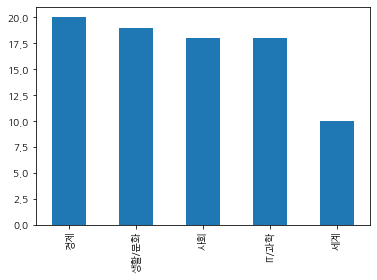

In [227]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
df['code'].value_counts().plot(kind = 'bar')

In [228]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     18
1     경제     20
2     사회     18
3  생활/문화     19
4     세계     10


In [229]:
#뉴스기사를 주제/섹션별로 모아서 데이터셋을 구축하고, 이를 기반으로 뉴스기사 주제를 분류하는 텍스트 분류기를 구현해 본다.

#Step 1. 형태소 분석기 변경해 보기

from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


분석 결과가 조금씩 차이가 난다
-로딩 시간 : Mecab < Okt < Kkma < Hannanum < Komoran
-분석 시간 : Mecab < Komoran < Okt < Hannanum < Kkma
결론적으로 Mecab의 성능이 가장 좋다.

In [230]:
#Step 2. 불용어 추가해 보기

stopwords = ['아','휴','아이구','에','은','는',
             '이','가','으로','로','에게','을','를',
             '뿐이다','하','한','때문','과','와','다',
             '이다','이면','면','의하여','됐다','했다','의','한편',
             '봤다','등','된','인','등','에는','까지','부터','하는',
            '지만','있','는데','데','파이낸셜','기자','뉴스','입력','수정','에서','서','텐데','때문에']

len(stopwords)

50

In [231]:
def preprocessing(data):
    text_data = []
    
    for sentence in data:
        temp_data = []
        
        #Tokenization
        temp_data = tokenizer.morphs(sentence)
        
        #Remove stopwords 
        temp_data = [word for word in temp_data if not word in stopwords]
        text_data.append(temp_data)
        
    #map : 함수 적용할 객체의 리스트를 반환한다, join: 공백으로 문자열을 연결한다,  
    text_data = list(map(' '.join, text_data))
    
    return text_data

In [232]:
text_data = preprocessing(df['news'])
print(text_data[0])

조수미 이정재 싸이 엑스포 장공 존 도시 부산 오 세요 엑스포 개최지 발표


In [233]:
#Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [234]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state= 0)

In [235]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 63
테스트용 뉴스 기사의 개수 :  22
훈련용 레이블의 개수 :  63
테스트용 레이블의 개수 :  22


In [236]:
#1.TF-IDF 벡터로 바꾼다 *TF measures how frequently a term occurs in a document
#2.나이브베이즈 분류기를 학습한다

#- 나이브 베이즈 분류기를 사용하기 위해 각 뉴스의 텍스트 데이터를 벡터로 변환
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [237]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfdif = tfidf_transformer.transform(data_counts)
    return data_tfdif

In [238]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [239]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [240]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [241]:
#Step 3. 다른 날짜 데이터 추가해 보기

In [242]:
#f1-score와 accuracy를 통해 성능을 확인해 볼 수 있습니다.

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.12      0.50      0.20         2
          경제       0.50      0.33      0.40         6
          사회       0.80      0.80      0.80         5
       생활/문화       0.60      0.50      0.55         6
          세계       0.00      0.00      0.00         3

    accuracy                           0.45        22
   macro avg       0.40      0.43      0.39        22
weighted avg       0.49      0.45      0.46        22



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
1. 한국어 전처리 과정이 적절하였는가? 	 형태소 분석기 선택과 불용어 제거가 체계적으로 진행됨
2. 텍스트 데이터 수집이 분량과 다양성 측면에서 적절했는가? 	 일자와 분량에서 텍스트 데이터 다양성 향상을 위한 노력이 확인됨
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가? 	 F-1 score 기준 83% 이상의 정확도가 확인됨